In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import statsmodels.tsa.api as smt
from itertools import combinations
import statsmodels.formula.api as sm
from statsmodels.api import stats as st
import statsmodels.api as sma
from statsmodels.api import ProbPlot, qqline
from IPython.display import display, Markdown, Latex
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.stats.diagnostic import het_white, het_breuschpagan


AX_SIZE = 10
FIG_WIDTH = 4
FIG_HEIGHT = 2.5

sns.set(font_scale=1.1, rc={"figure.figsize": [FIG_WIDTH, FIG_HEIGHT]})
sns.set_style('white')
sns.set_context('paper')
sns.set_palette('deep')

#Options
params = {'font.family':'STIXGeneral',
          'text.usetex' : True,
          'font.size' : 12,
          'figure.dpi':200
          }


plt.rcParams.update(params) 

pd.options.display.precision = 4 # Para 4 decimales.
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# esto es solo para que corra en mi compu je
import matplotlib
from matplotlib import rc
rc("text", usetex=False)
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
def format_plot(ax, x_label = 'x', y_label = 'y', caption = None, despine = True):
    if despine:
        sns.despine()

    if caption:
        x_label = x_label + '\n\n' + caption

    ax.set_xlabel(x_label, fontsize = AX_SIZE)
    ax.set_ylabel(y_label, fontsize = AX_SIZE)

# Introducción

Los datos analizados en el artículo [1] se componen de distintas variables relacionadas con el avance tecnológico de varios vehículos híbridos eléctricos. En este documento se utiliza el mismo conjunto de datos para construir, ajustar y validar un modelo de regresión lineal múltiple que explique el precio de los vehículos en términos de variables como la tasa de aceleración y el consumo de combustible entre otras. El ajuste obtenido es utilizado posteriormente para la predicción del precio de los vehículos de otro conjunto de datos.

# Resumen del artículo

En el artículo [1] se realiza un pronóstico de tecnología por medio de análisis por envolvente de datos (TFDEA por sus siglas en inglés) cuyo objetivo es medir y comparar el avance tecnológico ocurrido entre 2004 y 2013 en distintos sectores del mercado de vehículos híbridos eléctricos.

Los autores del artículo consideran como variable de entrada el precio sugerido por el fabricante de los vehículos. Como variables de salida consideran la tasa de aceleración, el consumo de combustible y el máximo de consumo de combustible o equivalente. También se incluye una variable categórica que divide a los vehículos en siete grupos diferentes.

De acuerdo con los resultados obtenidos en el artículo, los sectores correspondientes a los vehículos de tamaño medio fueron los que tuvieron mayores avances tecnológicos durante el periodo estudiado. Las mejoras en el desempeño y la diversificación de estos últimos puede representar una amenaza para los vehículos de tamaño pequeño. Mientras que los vehículos utilitarios deportivos (SUV) se enfocan en un nicho de mercado lujoso, los vehículos especializados para el transporte de mercancías compiten contra sus equivalentes de gasolina para probar la utilidad de los vehículos híbridos.

# Descripción de las variables del conjunto de datos y análisis exploratorio

El conjunto de datos cuenta con las siguientes variables

**Variable respuesta**

La variable de respuesta que se busca es el precio sugerido del vehículo (`msrp` por sus siglas en inglés), que toma valores decimales y que en los datos originales está expresada en dólares equivalentes a 2013. Los valores mínimo y máximo que se tienen son 11849.43 y 118543.6 respectivamente. Para expresar esta variable en miles de dólares, lo que hacemos es dividir esa columna entre 1000.


**Potenciales regresores**
* tasa de aceleración (`accelrate`): Esta variable numérica indica el tiempo en segundos que le toma a cada vehículo llegar de 0 km/h a 100 km/h.
* consumo de combustible (`mpg`): También conocida como economía de combustible, esta variable numéroca indica la distancia que un vehículo puede recorrer por unidad de combustible. En la fuente original de los datos se encuentra en millas por galón. En este documento se convirtió a kilómetros por litro multiplicando por 2.8248.
* máximo de consumo de combustible o equivalente (`mpgmpge`): La Agencia de Protección Ambiental de Estados Unidos desarrolló un consumo de combustible equivalente para los vehículos híbridos eléctricos. Esta variable indica el máximo entre el consumo de combustible tradicional y el equivalente. También se convirtió a kilómetros por litro.
* modelo (`vehicle`): Es una variable categórica que indica el modelo del  y que toma 109 valores diferentes.
* clase del vehículo (`carclass`): Es la categoría a la cual pertenece cada vehículo (detalle más adelante). 

A pesar de las transformaciones realizadas se decidió mantener el nombre original de las variables. Además los datos cuentan con otras variables: `carid`, `year` y `carclass_id` que son variables que no aportan mucho al análisis de los datos ya que son para el manejo interno de los datos o fungen como etiquetas.

In [4]:
#df = pd.concat([pd.read_csv('datosFit.csv'), pd.read_csv('datosFin.csv')]).reset_index(drop = True)
df = pd.read_csv('datosFit.csv')

In [5]:
data = df[['vehicle', 'accelrate', 'carclass']]
data['mpg'] = df['mpg'] * 0.425144
data['mpgmpge'] = df['mpgmpge'] * 0.425144
data['msrp'] = df['msrp'] / 1000

La base de datos se compone de 140 observaciones de diferentes coches y no tenemos datos faltantes ni repetidos. Existen 109 modelos de coches distintos y 7 clases.

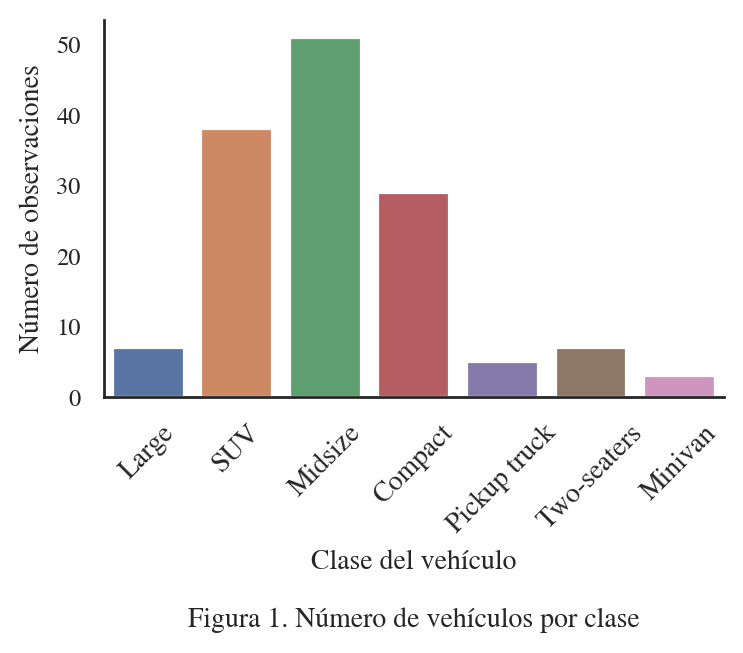

In [6]:
fig, axes = plt.subplots(1, 1)
sns.countplot(x = 'carclass', data = data, ax = axes)
axes.set_xticklabels(
    labels = ['Large', 'SUV', 'Midsize', 'Compact', 'Pickup truck', 'Two-seaters', 'Minivan'],
    rotation = 45,
    fontsize = AX_SIZE
)
format_plot(
    ax = axes,
    x_label = 'Clase del vehículo',
    y_label = 'Número de observaciones',
    caption = 'Figura 1. Número de vehículos por clase'
)
plt.show()

De la Figura 1 vemos que hay más carros de tamaño medio, seguido por las SUV y los autos compactos, por lo que la mayoría de los datos de la base son coches familiares donde caben más de 3 personas. Creamos una nueva variable para las clases de coche que agrupa los coches similares en una clase. Los nuevos grupos están dados por:

 * Carros grandes: Large y Pickup Truck (`Large`)
 * Camionetas: SUV y Minivan (`Vans`)
 * Carros pequeños: Compact y Two-seaters (`Small`)
 * Carros medianos: Midsize (`Medium`)
 
En lo subsecuente, la variable `carclass` se refiere a esta nueva asignación de categorías.

In [7]:
conditions = [
    (data['carclass'] == 'SUV') |  (data['carclass'] == 'MV'),
    (data['carclass'] == 'L') |  (data['carclass'] == 'PT'),
    (data['carclass'] == 'C') |  (data['carclass'] == 'TS'),
    (data['carclass'] == 'M')
]
choices = [
    'Vans',
    'Large',
    'Small',
    'Medium'
]
data['newCarClass'] = np.select(conditions, choices)

De igual manera se creó una nueva variable para el modelo de coche que agrupa los modelos por marca, por ejemplo: *Prius*, *Highlander* y *Camry* son de la marca *Toyota*. De esta manera, la nueva variable `manufacturer` se redujo a 25 clases en lugar de las 103 de la variable `vehicle`. En la Figura 2 vemos que *Toyota*, *Honda*, *Lexus*, *Chevrolet* y *Ford* son las marcas con más observaciones.

In [8]:
vehicles = {}
for model in data.vehicle.unique():
    key = model.split()[0]
    
    if key in vehicles:
        vehicles[key].append(model)
    else:
        vehicles[key] = [model]

conditions = []
choices = []
for key, values in vehicles.items():
    for model in values:
        conditions.append(df['vehicle'] == model)
        choices.append(key)
data['model'] = np.select(conditions, choices)

In [9]:
brand = {
    'BMW': ['ActiveHybrid', ],
    'Mercedes-Benz': ['ML450', 'S400', 'E400'],
    'Toyota': ['Crown', 'Prius', 'SAI', 'Highlander', 'Auris', 'Camry', 'Kluger', 'Estima', 'Aqua', 'Alphard'],
    'BYD': ['F3DM'],
    'Lexus': ['ES', 'CT', 'GS', 'Lexus', 'RX', 'HS'],
    'Chevrolet': ['Silverado', 'Tahoe', 'Malibu', 'Chevrolet'],
    'Honda': ['Civic', 'CR-Z', 'Fit', 'Insight', 'Freed/Freed', 'ILX', 'Fit/Jazz', 'Accord'],
    'Nissan': ['Altima', 'Tino', 'Fuga'],
    'Cadillac': ['Cadillac', 'Escalade'],
    'Dodge': ['Aspen', 'Durango'],
    'Ford': ['Escape', 'Fusion', 'C-Max', 'Mercury', 'Mariner'],
    'Audi': ['A5', 'Q5', 'Audi'],
    'Kia': ['Optima'],
    'Infiniti': ['M35h'], 
    'Volkswagen': ['Touareg', 'Jetta'],
    'Opel': ['Ampera', 'Vue'], 
    'GMC': ['Yukon', 'Sierra', 'GMC'],
    'Mazda': ['Tribute'],
    'Lincoln': ['MKZ', 'Lincoln'],
    'Hyundai': ['Sonata', 'Avante/Elantra', 'Aura'], 
    'Porsche': ['Panamera', 'Cayenne'], 
    'Jeep': ['Jeep'],
    'Besturn': ['Besturn'],
    'Buick': ['Buick', 'LaCrosse', 'Regal'], 
    'Peugeot': ['3008']
}

conditions = []
choices = []
for key, values in brand.items():
    for model in values:
        conditions.append(data['model'] == model)
        choices.append(key)
data['manufacturer'] = np.select(conditions, choices)


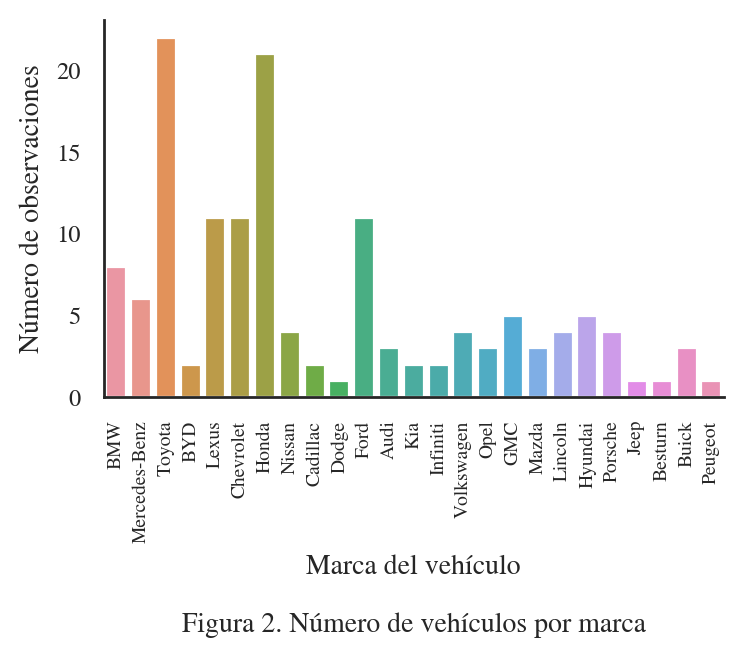

In [10]:
fig, axes = plt.subplots(1, 1)
sns.countplot(x = 'manufacturer', data = data, ax = axes)
axes.set_xticklabels(
    labels = data.manufacturer.unique(),
    rotation = 90,
    fontsize = 7
)
format_plot(
    ax = axes,
    x_label = 'Marca del vehículo',
    y_label = 'Número de observaciones',
    caption = 'Figura 2. Número de vehículos por marca'
)
plt.show()

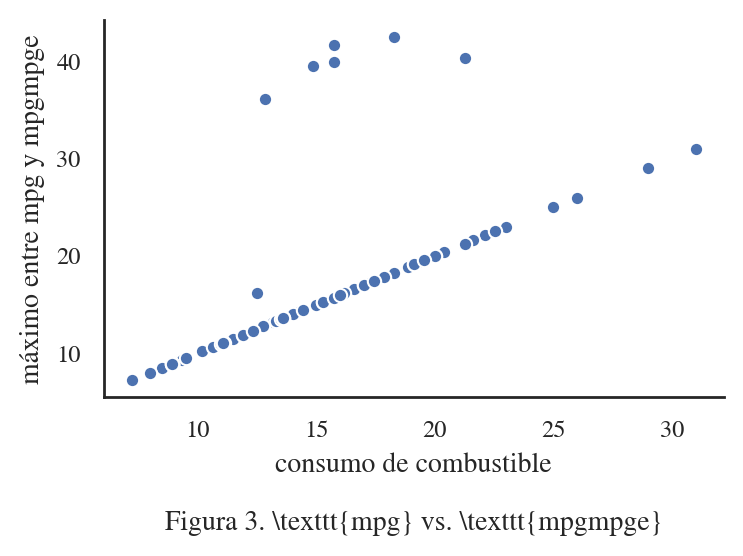

In [11]:
diff_indices = np.where(data['mpg'] != data['mpgmpge'])
different = data.loc[diff_indices]
different = different.sort_values(by = 'mpgmpge')


fig, axes = plt.subplots(1, 1)
sns.scatterplot(x = 'mpg', y = 'mpgmpge', data = data)
format_plot(
    ax = axes,
    x_label = 'consumo de combustible',
    y_label = 'máximo entre mpg y mpgmpge',
    caption = 'Figura 3. \\texttt{mpg} vs. \\texttt{mpgmpge}'
)
plt.show()

Para la mayoría de las observaciones el consumo de combustible es igual al máximo entre el `mpg` y la medición alternativa del consumo de combustible. Sin embargo, hay 11 observaciones en las que la medición alternativa es más del doble de `mpg` (Figura 3).

A continuación evaluaremos la relación lineal entre los regresores y la variable respuesta. 

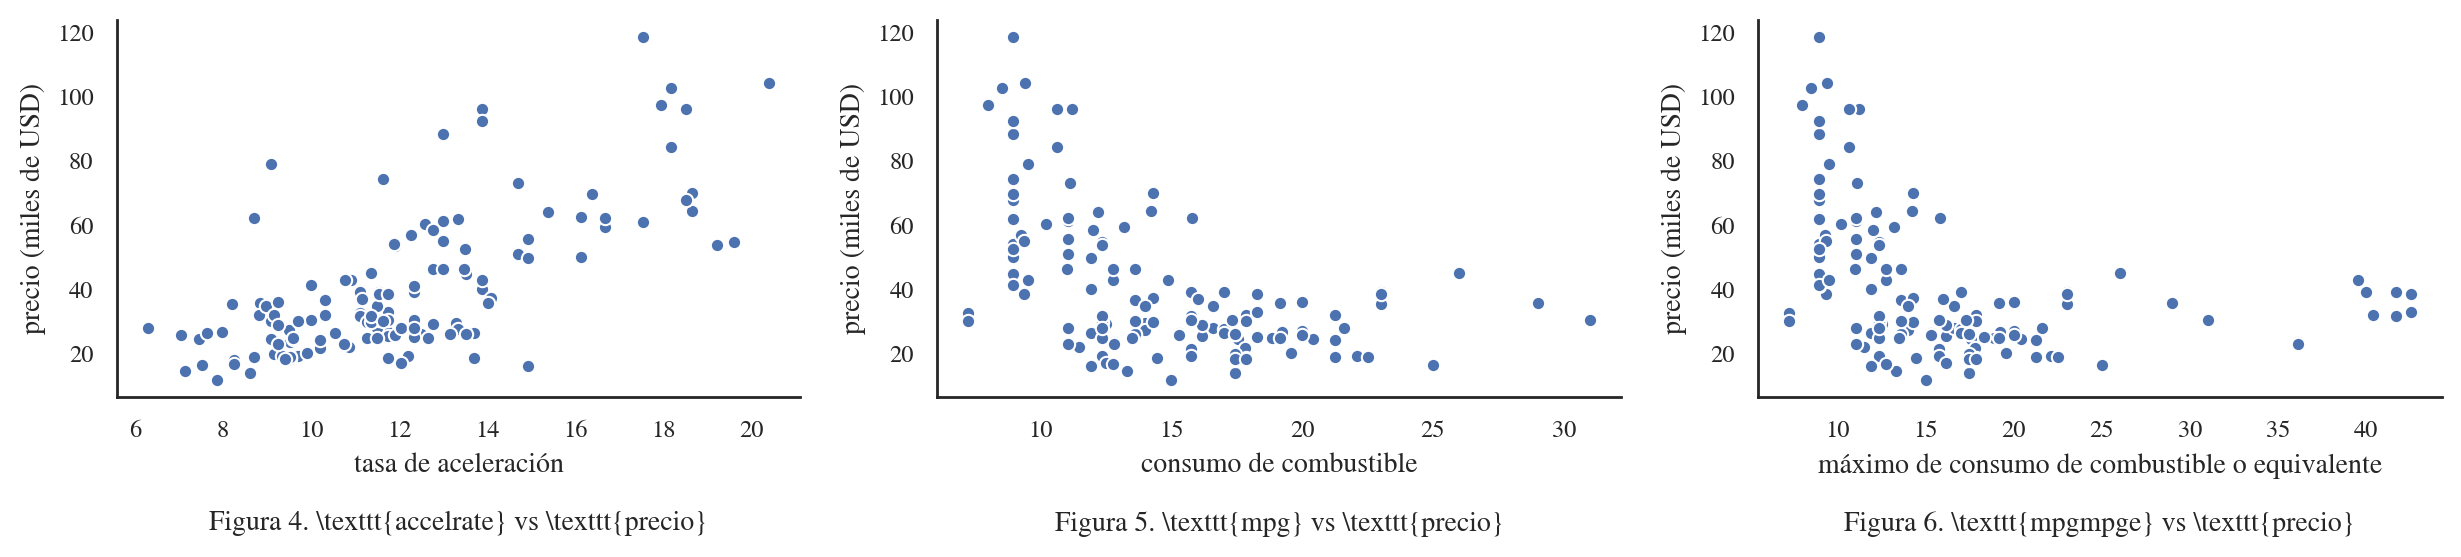

In [12]:
fig, axes = plt.subplots(1, 3, figsize = ((FIG_WIDTH+1)*3, FIG_HEIGHT))
xs = ['accelrate', 'mpg', 'mpgmpge']
labels  = ['tasa de aceleración', 'consumo de combustible', 'máximo de consumo de combustible o equivalente']
captions = ['\\texttt{accelrate}', '\\texttt{mpg}', '\\texttt{mpgmpge}']

i = 4
for x, label, ax, c in zip(xs, labels, axes, captions):
    # accelrate
    sns.scatterplot(x = x, y = 'msrp', data = data, ax = ax)
    caption = f'Figura {i}. '
    caption += c
    caption += ' vs \\texttt{precio}'
    format_plot(
        ax = ax,
        x_label = label,
        y_label = 'precio (miles de USD)',
        caption = caption
    )
    i += 1

plt.show()

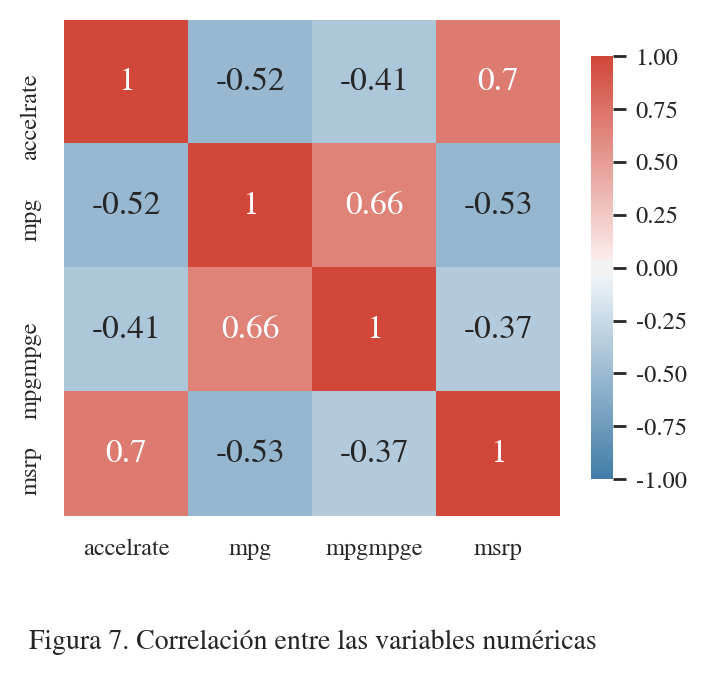

In [13]:
plt.figure(figsize=(4, 4))
cmap = sns.diverging_palette(240, 15, as_cmap=True)
ax = sns.heatmap(data.corr(),
            vmin = -1,
            square=True,
            cmap=cmap,
            annot=True,
            cbar_kws={"shrink": .7}
)

format_plot(
    ax = ax,
    despine = False,
    x_label = '', 
    y_label = '',
    caption = 'Figura 7. Correlación entre las variables numéricas'
)

plt.show()

La tasa de aceleración es la única que presenta una correlación lineal clara con el precio (Figura 4). Tanto para el consumo de combustible como para el máximo de consumo de combustible o equivalente, la relación con la variable objetivo es no-lineal (Figuras 5 y 6). También podemos ver que las variables `mpg` y `mpgmpge` tienen un comportamiento similar, lo cual tiene sentido ya que solo difieren en 11 observaciones.

Esto se puede confirmar en la Figura 7 ya que `accelrate` tiene una correlación de $0.7$ con la variable objetivo, mientras que para `mpg` y `mpgmpge`, además de que las correlaciones son negativas, estas no son muy grandes en magnitud.

# Modelo de regresión lineal múltiple

## Modelo inicial

En primer lugar, se ajustó un modelo de regresión lineal tomando como respuesta a la variable `msrp` y como regresores a las variables numéricas `accelrate`, `mpg` y `mpgmpge` y a los factores `carclass`, `manufacturer`.

In [14]:
formula = 'msrp~accelrate+mpg+mpgmpge+newCarClass+manufacturer'
modelo = sm.ols(formula=formula, data = data)
fitted = modelo.fit()

In [15]:
txt = 'Vemos que `mpg` no es significativo pues tiene un valor-p ${:.3f} > 0.05$'.format(fitted.pvalues['mpg'])
display(Markdown(txt))

Vemos que `mpg` no es significativo pues tiene un valor-p $0.081 > 0.05$

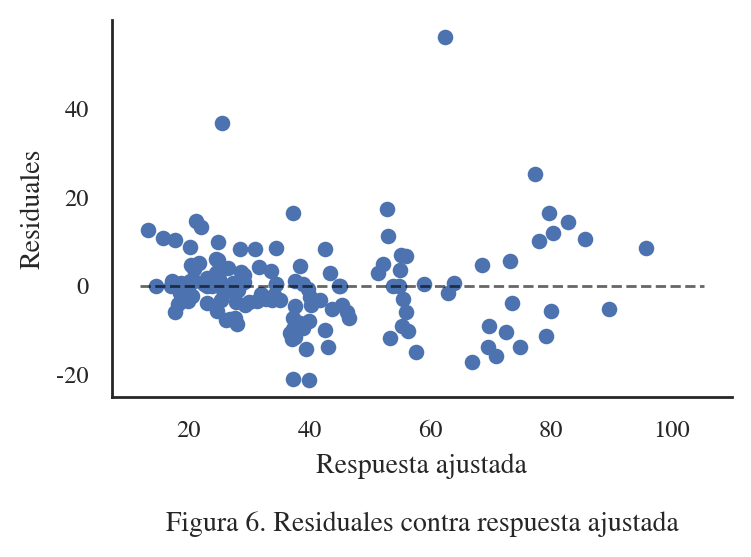

In [16]:
fig, axes = plt.subplots(1, 1)
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, fitted.resid)

format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales',
    caption = 'Figura 6. Residuales contra respuesta ajustada'
)
plt.show()

En la Figura 6 se encunetran graficados los residuales contra las respuestas ajustadas del obtenidas a partir del modelo inicial. La gráfica sugiere una desviación notable del supuesto de varianza constante de los términos aleatorios de error.

## Transformación de variables

Con el objetivo de mitigar las desviaciones de los supuestos del modelo de regresión lineal se utilizó la transformación de Box-Cox en la variable respuesta. Para obtener un valor de $\lambda$ óptimo se consideraron varios valores de prueba. Con cada uno de ellos se obtuvo un ajuste y se seleccionó el valor de $\lambda$ que minimizara la suma de cuadrados de los residuales de cada uno de los ajustes.  En la Tabla 1 se muestra que el valor óptimo resultó ser $\lambda = 0$, lo cual sugiere que la varianza de los términos de error podría estabilizarse al aplicar una transformación logarítmica a la variable respuesta.

In [17]:
def get_boxcox(y, y_gmean, l):
    if l != 0:
        aux = np.power(y, l)-1
        return aux/(l*np.power(y_gmean, l-1))
    else:
        return y_gmean*np.log(y)
    
def get_lambda(df, regresors, y, l_lb = -1, l_ub = 1,  num_l = 9):
    y_gmean = stats.mstats.gmean(df[y])
    
    lambdas = np.linspace(l_lb, l_ub, num_l)
    SS_trans_res = []
    
    for l in lambdas:
        trans_df = df[regresors]
        trans_df['yBoxCox'] = get_boxcox(y = df[y], l = l, y_gmean = y_gmean)
        formula = 'yBoxCox~{}'.format('+'.join(regresors))
        model = sm.ols(formula=formula, data = trans_df)
        fitted = model.fit()
        SS_trans_res.append(fitted.mse_resid*fitted.df_resid)

    min_index = SS_trans_res.index(min(SS_trans_res))
    l = lambdas[min_index]
    classification = [" " for i in range(0,len(lambdas))]
    classification[min_index] = "Óptimo"

    dictionary = {"$\lambda$": lambdas, "$SC_{{Res}}(\lambda)$": SS_trans_res, "Clasificación": classification}
    lambda_df = pd.DataFrame.from_dict(dictionary)
    return lambda_df

In [18]:
regresors = ['accelrate', 'mpgmpge', 'newCarClass', 'manufacturer']
lambda_df = get_lambda(
    df = data,
    regresors = regresors,
    y = 'msrp',
    l_lb = -1,
    l_ub = 1, 
    num_l = 9
)

# QUITAR SI NO CORRE AL CONVERTIR A LATEX/PDF
title = r"Tabla 1. Valores de prueba de $\lambda$ para la transformación de Box-Cox"
lambda_df = lambda_df.style.set_caption(title)

display(lambda_df)

,$\lambda$,$SC_{{Res}}(\lambda)$,Clasificación
0,-1.0000,10269.7716,
1,-0.7500,8874.2238,
2,-0.5000,7989.9042,
3,-0.2500,7546.4395,
4,0.0000,7525.9739,Óptimo
5,0.2500,7963.9670,
6,0.5000,8959.1730,
7,0.7500,10695.3245,
8,1.0000,13479.5726,


In [19]:
res = stats.boxcox(data['msrp'], alpha = 0.05)
print('lambda: {:.3f}'.format(res[1]))
print('CI: {}'.format(res[2]))

lambda: -0.356
CI: (-0.6767251775288341, -0.037340931198571285)


## Modelo final

Para la selección del modelo final se utilizó un procedimiento computacional que consiste en evaluar todas las posibles regresiones. Los parámetros de evaluación fueron el Criterio de Información de Akaike (AIC) y la $C_p$ de Mallows y el valor $p$ asociado con el estadístico $F$ de la significancia de la regresión.

In [20]:
data_fin = pd.DataFrame()
data_fin['msrp'] = stats.boxcox(x = data['msrp'], lmbda = 0)
data_fin['mpg'] = data['mpg']
data_fin['mpgmpge'] = data['mpgmpge']
data_fin['carclass'] = data['newCarClass']
data_fin['accelrate'] = data['accelrate']
data_fin['manufacturer'] = data['manufacturer']

In [21]:
def fit_model(regresors, df):
    formula = 'msrp~{}'.format('+'.join(regresors))
    modelo = sm.ols(formula=formula, data = df)
    fitted = modelo.fit()
    
    pval = str(fitted.f_pvalue)
    int_, extra = pval.split('.')
    decimal, exp = extra.split('e')
    decimal = decimal[:3]
    f_pvalue = '{}.{}e{}'.format(int_,decimal,exp)
    
    classes_nonsig = 0
    manufacturers_nonsig = 0
    others = []
    for regresor, p in zip(fitted.pvalues.index, fitted.pvalues):
        if p > 0.05:
            if 'carclass' in regresor:
                classes_nonsig += 1
            elif 'manufacturer' in regresor:
                manufacturers_nonsig += 1
            else:
                others.append(regresor)
                
    if 'carclass' in regresors:
        classes_nonsig = np.round((classes_nonsig/data_fin.carclass.nunique())*100,2)
    else:
        classes_nonsig = '-'
        
    if 'manufacturer' in regresors:
        manufacturers_nonsig = np.round((manufacturers_nonsig/data_fin.manufacturer.nunique())*100,2)
    else:
        manufacturers_nonsig = '-'
        
    # mallows cp
    n = data.shape[0]
    q = fitted.params.shape[0]#len(regresors)
    cp = ((fitted.mse_model*fitted.df_resid)/fitted.mse_model) - n + 2*q
    
    d = {
        'model': '+'.join(regresors),
        'num_regresors': q,
        'AIC': np.round(fitted.aic, 3),
        'Mallows Cp': cp,
        'f_pvalue': f_pvalue,
        'R2 adj': np.round(fitted.rsquared_adj*100, 2),
        '% carclass ns': classes_nonsig,
        '% manufacturer ns': manufacturers_nonsig,
        'others': ','.join(others)
    }
    
    return d

In [22]:
possible_regresors = ['mpg', 'mpgmpge', 'carclass', 'accelrate', 'manufacturer']
m = len(possible_regresors)
params = [r for n in range(1, m+1) for r in combinations(possible_regresors, n)]# if 'accelrate' in r]

models_info = []
for regresors in params:
    models_info.append(
        fit_model(regresors = regresors, df = data_fin)
    )

models_df = pd.DataFrame(models_info)
models_df = models_df[models_df['others'] == '']
models_df = models_df.drop(columns = 'others')

# QUITAR SI NO CORRE AL CONVERTIR A LATEX/PDF
title = r"Tabla 2. Estadísticos relevantes para la selección del modelo final"
models_df = models_df.style.set_caption(title)

display(models_df.filter(["model", "num_regresors", "AIC", "Mallows Cp", "f_pvalue"]))

AttributeError: 'Styler' object has no attribute 'filter'

En la Tabla 2 se muestra que el modelo que simultáneamente minimiza el valor del AIC y el valor $p$ asociado con el estadístico $F$ de la prueba de la significancia de la regresión es el que se muestra en la última fila de la tabla, es decir, aquel que considera a `mpgmpge`, `carclass`, `accelrate` y `manufacturer`como regresores. En todos los casos la $C_p$ de Mallows es igual a la cantidad de regresores empleados. La cantidad de 30 regresores corresponde a (25 - 1) variables indicadoras asociadas con el factor `manufacturer`, (4 - 1) variables indicadoras asociadas con el factor `carclass`, 2 variables numéricas y 1 regresor asociado con el coeficiente $\beta_0$

In [23]:
formula = 'msrp~mpgmpge+carclass+accelrate+manufacturer'
modelo = sm.ols(formula=formula, data = data_fin.drop(index = []))
fitted = modelo.fit()

## Detección de valores atípicos

Para la detección de valores atípicos se calcularon los residuales estandarizados ($\hat{r}_i$) y las distancias de Cook ($d_i$). Con base en el criterio $|\hat{r}_i| > 3$ se detectaron dos valores atípicos: El vehículo cuyo modelo es `Crown`y el vehículo cuyo modelo es `Lexus LS600h/hL`. Esta situación se encuentra ilustrada en la Figura 7. No se detectaron valore de influencia con el criterio $d_i > 1$.

In [24]:
influence = fitted.get_influence()

#leverage (hat values)
leverage = influence.hat_matrix_diag

#Cook's D values (and p-values) as tuple of arrays
cooks_d = influence.cooks_distance
cooks_d = [x[0] for x in cooks_d]

#standardized residuals
standardized_residuals = influence.resid_studentized_internal

#studentized residuals
studentized_residuals = influence.resid_studentized_external

print('\nH:')
p = len(fitted.params) - 1
n = data.shape[0]
threshold = 2*p/n
apalancamiento = []
for i, h_ii in enumerate(leverage):
    if np.abs(h_ii) > threshold:
        apalancamiento.append(i)
        
df_leverage = data.loc[apalancamiento]
df_leverage = df_leverage[df_leverage['newCarClass'] != 'Large']
apalancamiento = df_leverage.index.tolist()
print(apalancamiento)

print('\nStd:')
s = np.sqrt(fitted.mse_resid)
std_resid = fitted.resid/s
outliers = []
for i, e in enumerate(standardized_residuals):
    if np.abs(e) > 3:
        print('{} es atipico {:.2f}'.format(i, e))
        outliers.append(i)
        
print('\nCooks:')
D = (np.square(standardized_residuals) * leverage)/(p*(1-leverage))
cooks = []
for i, d in enumerate(cooks_d):
    if d > 1:
        print('{} es influyente {:.2f}'.format(i, d))
        cooks.append(i)
        
cooks = 19

/home/moni/.pyenv/versions/my-virtual-env-3.7.4/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:693: RuntimeWarning: invalid value encountered in sqrt
  return self.resid / sigma / np.sqrt(1 - hii)
/home/moni/.pyenv/versions/my-virtual-env-3.7.4/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/home/moni/.pyenv/versions/my-virtual-env-3.7.4/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:903: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/home/moni/.pyenv/versions/my-virtual-env-3.7.4/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1912: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)



H:
[3, 15, 16, 17, 19, 24, 30, 62, 72, 100, 105, 127, 130]

Std:
2 es atipico 4.12
89 es atipico 3.60

Cooks:


2
89


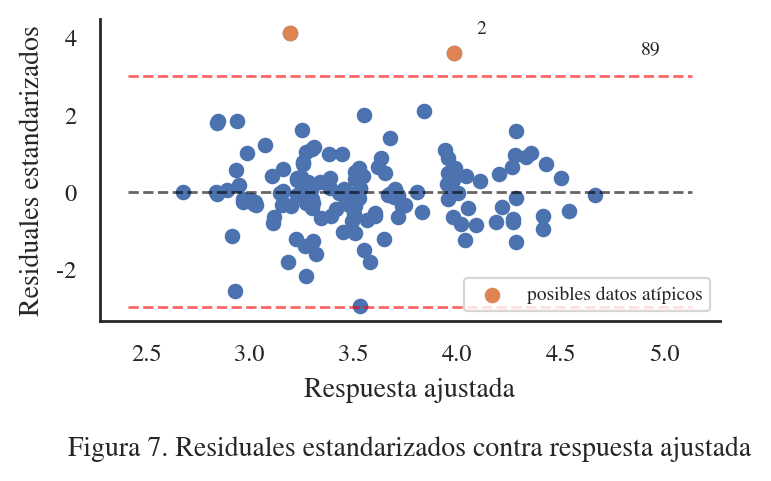

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(4, 2))
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=3, xmin=xmin*0.9, xmax=xmax*1.1, color='red',linestyle='--',lw=1, alpha = 0.6)
axes.hlines(y=-3, xmin=xmin*0.9, xmax=xmax*1.1, color='red',linestyle='--',lw=1, alpha = 0.6)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, standardized_residuals)
axes.scatter(fitted.fittedvalues[outliers], standardized_residuals[outliers], label = 'posibles datos atípicos')
plt.legend(loc = 4, fontsize = 7)
format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales estandarizados',
    caption = 'Figura 7. Residuales estandarizados contra respuesta ajustada'
)

for i in outliers:
    print(i)
    axes.annotate(i, 
                  xy=(fitted.fittedvalues[i]+0.9, standardized_residuals[i]),
                  size = 7
                 )

plt.show()

In [26]:
crown_df = data_fin[(data_fin["accelrate"] >= 8.70 - 2) & (data_fin["accelrate"] <= 8.70 + 2) & (data_fin["carclass"] == "Medium")].sort_values("msrp")

# QUITAR SI NO CORRE AL CONVERTIR A LATEX/PDF
title = 'Tabla 3. Vehículos con "accelrate" entre 6.70 y 10.70 y con "carcalss" == "Medium"'
crown_df = crown_df.style.set_caption(title)

display(crown_df)

,msrp,mpg,mpgmpge,carclass,accelrate,manufacturer
19,2.4723,14.9991,14.9991,Medium,7.8700,Audi
100,2.6801,13.2985,13.2985,Medium,7.1400,Besturn
116,3.0134,19.5566,19.5566,Medium,9.9000,Toyota
105,3.1409,12.8181,36.1372,Medium,9.2400,BYD
3,3.1673,12.8011,36.1372,Medium,9.5200,BYD
108,3.1864,21.2572,21.2572,Medium,10.2000,Toyota
49,3.2096,12.3292,12.3292,Medium,9.0900,Chevrolet
62,3.2790,15.3052,15.3052,Medium,10.5400,Kia
33,3.3059,14.0000,14.0000,Medium,9.5100,Toyota
40,3.4206,31.0015,31.0015,Medium,10.0000,Toyota


En la Tabla 3 se muestra que el vehículo `Crown` es el único de la clase `Medium` cuyo `accelrate` se encuentra entre 6.70 y 10.70 que tiene un precio en miles de dólares de 2013 `msrp` mayor a 40.

Además de que una situación similar se presenta para el caso del vehículo `Lexus LS600h/hL`, sucede que este es el vehículo más caro de todo el conjunto de datos con un `msrp` de 118.5436 miles de dólares de 2013.

Se ha decidido conservar estas observaciones debido a que no hay evidencia suficiente para concluir que la atipicidad de sus valores pueda ser atribuida a errores incurridos durante la recolección de los datos.

### Validación del modelo

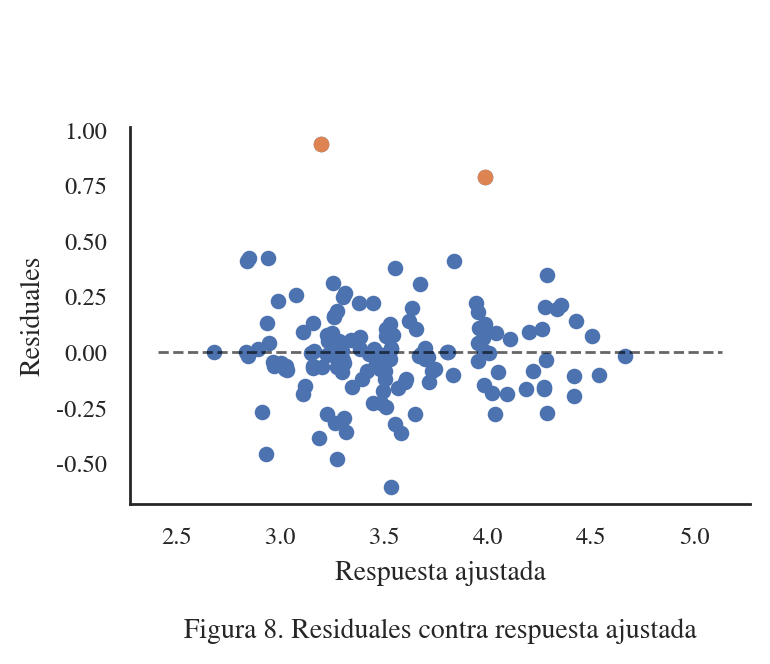

In [27]:
fig, axes = plt.subplots(1, 1)
# grafica residuales
xmin=min(fitted.fittedvalues)
xmax = max(fitted.fittedvalues)
axes.hlines(y=0, xmin=xmin*0.9, xmax=xmax*1.1, color='black',linestyle='--',lw=1, alpha = 0.6)
axes.scatter(fitted.fittedvalues, fitted.resid)

## Quitar esto para no graficar outliers
axes.scatter(fitted.fittedvalues[outliers], fitted.resid[outliers])

for i in outliers:
    axes.annotate(i, 
                  xy=(fitted.fittedvalues[i]+0.9, fitted.resid[i]+0.5),
                  size = 7
                 )

format_plot(
    axes,
    x_label = 'Respuesta ajustada',
    y_label = 'Residuales',
    caption = 'Figura 8. Residuales contra respuesta ajustada'
)
plt.show()

En la Figura 8 se encuentran graficados los residuales contra las respuestas ajustadas obtenidas a partir del modelo final seleccionado. En comparación con la Figura 6, el problema de heteroscedasticidad fue ligeramente mitigado.

AttributeError: module 'seaborn' has no attribute 'histplot'

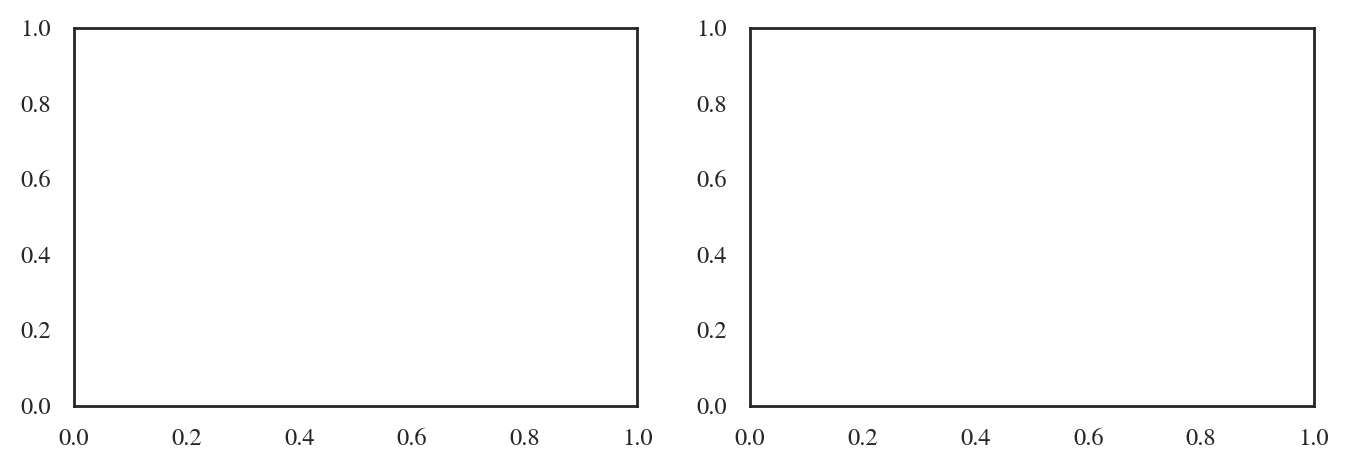

In [28]:
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
# Histograma
sns.histplot(fitted.resid, ax = axes[0], kde = True)
format_plot(
    ax = axes[0],
    x_label = 'residuales',
    y_label = '',
    caption = 'Figura 9. Histograma de los residuales'
)
#Gráfica cuantil-cuantil
pp = ProbPlot(fitted.resid_pearson, fit=True)
qq = pp.qqplot(alpha=0.6, ax = axes[1])

# annotations
abs_norm_resid = np.flip(np.argsort(np.abs(fitted.resid_pearson)), 0)
abs_norm_resid_top_3 = abs_norm_resid[:2]

for r, i in enumerate(abs_norm_resid_top_3):
    axes[1].annotate(i, 
                     xy=(np.flip(pp.theoretical_quantiles, 0)[r],
                                   fitted.resid_pearson[i]),
                    size = 8)    


qqline(qq.axes[1], line='45', color='black',linestyle='--',lw=1, alpha = 0.6)
format_plot(
    axes[1],
    x_label = 'Residuales',
    y_label = 'Escala normal',
    caption = 'Figura 10. Gráfica cuantil-cuantil'
)
plt.show()


En la Figura 9 se encuentra un histograma de los resiudales que sugiere que, salvo por algunas observaciones, el supuesto de normalidad no está siendo del todo violado. Esto se evidencia con mayor claridad en la Figura 10, que es una gráfica cuantil-cuantil de los residuales contra la escala normal. Salvo por los valores influyentes mencionados previamente, la desviación del supuesto de normalidad no es muy grave.

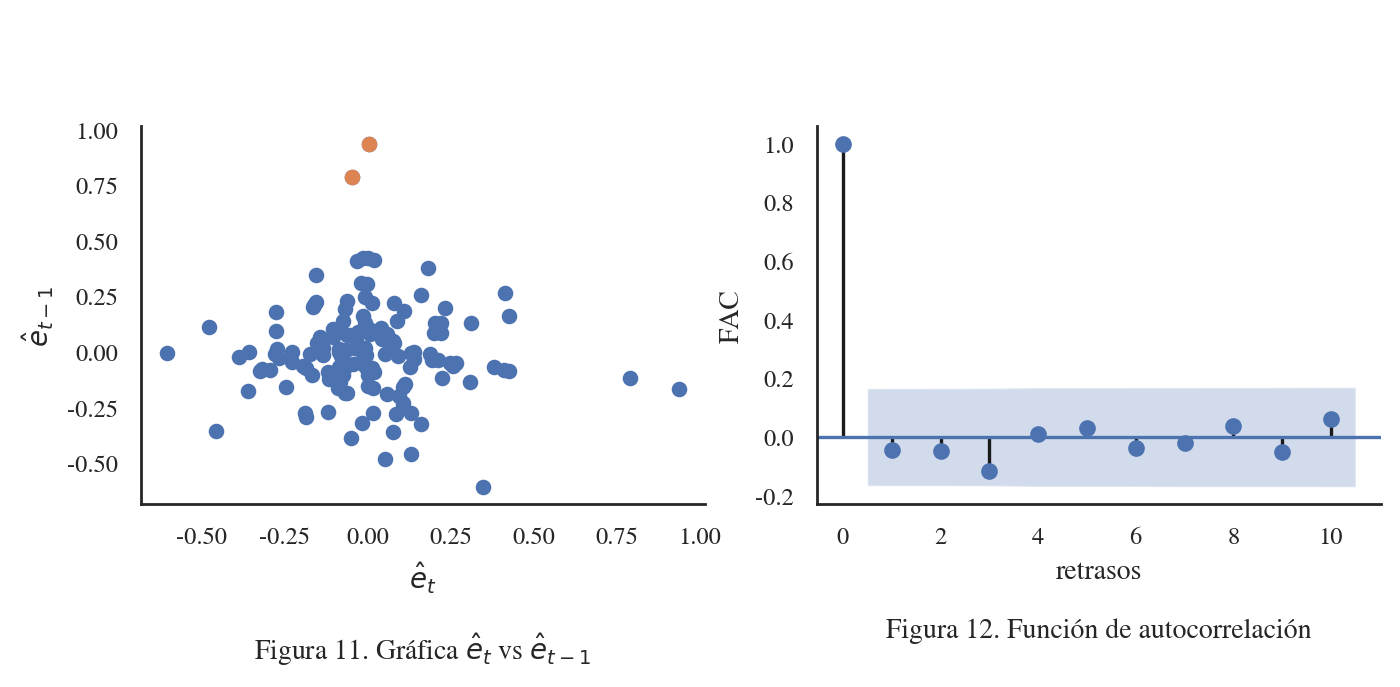

In [29]:
#------------------------------------------------
fig, axes = plt.subplots(1, 2, figsize=(FIG_WIDTH*2, FIG_HEIGHT))
#plot acf
e1 = list(fitted.resid)
e = e1[:-1]
e1 = e1[1:]
axes[0].scatter(x = e1, y = e)

# quitar si no se grafican outliers
axes[0].scatter(x = np.array(e1)[outliers], y = np.array(e)[outliers])
for i in outliers:
    axes[0].annotate(i, 
                  xy=(e1[i]+0.9, e[i]+0.5),
                  size = 7
                 )
    
format_plot(
    axes[0],
    x_label = '$\hat{e}_t$',
    y_label = '$\hat{e}_{t-1}$',
    caption = 'Figura 11. Gráfica $\hat{e}_t$ vs $\hat{e}_{t-1}$'
)
smt.graphics.plot_acf(
    fitted.resid, 
    lags=10, 
    alpha=0.05,
    ax = axes[1],
    title = ''
)
format_plot(
    axes[1],
    x_label = 'retrasos',
    y_label = 'FAC',
    caption = 'Figura 12. Función de autocorrelación'
)
plt.show()

In [30]:
# Aquí me robé el texto que puso Andrea en el control 3 :D

Finalmente con la Figura 11 y la Figura 12 vemos que los residuales no presentan ninguna correlación aparente entre ellos y que la correlación de orden uno es muy pequeña por lo que también se cumple el supuesto de independencia.

In [31]:
# coches muy caros dentro de su categoría (???)
#data.loc[outliers]

# Predicción del precio de nuevos vehículos

In [32]:
# <font color='red'>Dar intervalos de confianza para las predicciones y el valor de R^2 de la predicción (pg 377 Montgomery inglés)</font>

In [33]:
newDf = pd.read_csv('datosFin.csv')
datos_fin = pd.DataFrame()
# print(newDf)
datos_fin['vehicle'] = newDf['vehicle']
datos_fin['accelrate'] = newDf['accelrate']
datos_fin['carclass'] = newDf['carclass']
datos_fin['mpg'] = newDf['mpg']
datos_fin['mpgmpge'] = newDf['mpgmpge']
datos_fin['msrp'] = newDf['msrp']


conditions = [
    (datos_fin['carclass'] == 'SUV') |  (datos_fin['carclass'] == 'MV'),
    (datos_fin['carclass'] == 'L') |  (datos_fin['carclass'] == 'PT'),
    (datos_fin['carclass'] == 'C') |  (datos_fin['carclass'] == 'TS'),
    (datos_fin['carclass'] == 'M')
]
choices = [
    'Vans',
    'Large',
    'Small',
    'Medium'
]

datos_fin['newCarClass'] = np.select(conditions, choices)

vehicles = {}
for model in datos_fin.vehicle.unique():
    key = model.split()[0]
    
    if key in vehicles:
        vehicles[key].append(model)
    else:
        vehicles[key] = [model]
conditions = []
choices = []
for key, values in vehicles.items():
    for model in values:
        conditions.append(newDf['vehicle'] == model)
        choices.append(key)
datos_fin['model'] = np.select(conditions, choices)

conditions = []
choices = []
for key, values in brand.items():
    for model in values:
        conditions.append(datos_fin['model'] == model)
        choices.append(key)
datos_fin['manufacturer'] = np.select(conditions, choices)

datos_fin['mpg'] = datos_fin['mpg'] * 0.425144
datos_fin['mpgmpge'] = datos_fin['mpgmpge'] * 0.425144


Recordemos que nuestro modelo está dado por: 

\begin{equation}
    y = 2.5233 + \begin{pmatrix}
       -0.2331 \\
       -0.2592 \\ 
       0.0038
    \end{pmatrix}' \begin{pmatrix}
       Medium \\
       Small \\ 
       Vans
    \end{pmatrix} + \begin{pmatrix}
        0.7806 \\
       -0.0849 \\ 
       -0.1878 \\
        0.2666 \\
        1.0763 \\
        0.3199 \\
        0.3493 \\
        0.0759 \\
        0.5968 \\
       -0.0630 \\
        0.0789 \\
        0.3755 \\
       -0.6023 \\
        0.1295 \\
        0.5186 \\
        0.3632 \\
       -0.1374 \\
        0.8580 \\
        0.2471 \\
       -0.1051 \\
        0.5763 \\
        0.6483 \\
        0.2047 \\
        0.3373
    \end{pmatrix}' \begin{pmatrix}
       BMW \\
       BYD \\
       Besturn \\
       Buick \\
       Cadillac \\
       Chevrolet \\
       Dodge \\
       Ford \\
       GMC \\
       Honda \\
       Hyundai \\
       Infiniti \\
       Jeep \\
       Kia \\
       Lexus \\
       Lincoln \\
       Mazda \\
       Mercedes-Benz \\
       Nissan \\
       Opel \\
       Peugeot \\
       Porsche \\
       Toyota \\
       Volkswagen
    \end{pmatrix} + 0.0102*mpgmpge + 0.0620*accelrate
\end{equation}

In [34]:
# print(datos_fin)
def predicted_price(mpgmpge, carClass, manufacturer, accelrate):
    carclass_switch = {
        'Medium': -0.2331,
        'Small': -0.2592,
        'Vans': 0.0038
    }
    
    manufacturer_switch = {
        'BMW': 0.7806,
        'BYD': -0.0849,
        'Besturn': -0.1878,
        'Buick': 0.2666,
        'Cadillac': 1.0763,
        'Chevrolet': 0.3199,
        'Dodge': 0.3493,
        'Ford': 0.0759,
        'GMC': 0.5968,
        'Honda': -0.0630,
        'Hyundai': 0.0789,
        'Infiniti': 0.3755,
        'Jeep': -0.6023,
        'Kia': 0.1295,
        'Lexus': 0.5186,
        'Lincoln': 0.3632,
        'Mazda': -0.1374,
        'Mercedes-Benz': 0.8580,
        'Nissan': 0.2471,
        'Opel': -0.1051,
        'Peugeot': 0.5763,
        'Porsche': 0.6483,
        'Toyota': 0.2047,
        'Volkswagen': 0.3373
    }
    
    return 2.5233 + float(carclass_switch.get(carClass, 0)) + float(manufacturer_switch.get(manufacturer,0)) + 0.0102*float(mpgmpge) + 0.0620*float(accelrate) 


Para poder predecir los nuevos datos que tenemos, primero se tienen que hacer las mismas modificaciones que se hicieron con los datos de entrenamiento. Es decir, dividir el `msrp` entre 1000, expresar las columnas `mpg` y `mpgmpge` en términos de kilómetros por litro y clasificar las clases y las marcas de los vehículos como se hizo previamente. Una vez realizados estos cambios, procedemos a hacer la predicción y a analizar los resultados obtenidos.

In [35]:
# Para obtener los intervalos de confianza

datos_fin_modified = pd.DataFrame()
datos_fin_modified['mpgmpge'] = datos_fin['mpgmpge']
datos_fin_modified['carclass'] = datos_fin['newCarClass']
datos_fin_modified['model'] = datos_fin['model']
datos_fin_modified['accelrate'] = datos_fin['accelrate']
datos_fin_modified['manufacturer'] = datos_fin['manufacturer']
datos_fin_modified['msrp'] = datos_fin['msrp']/1000
datos_fin_modified['mpg'] = datos_fin['mpg']
datos_fin_modified['mpgmpge'] = datos_fin['mpgmpge']


def predict(df, fitted_model, mean = 'y_approx', ci_upper = 'CI_upper', ci_lower = 'CI_lower'):
    prediction = fitted_model.get_prediction(df)
    
    df[mean] = prediction.predicted_mean
    
    df[ci_lower], df[ci_upper] = prediction.conf_int().T
        
    return df

def plot_ci(modelos, ci_lower, ci_upper, y, y_approx, label):
    fig, ax = plt.subplots(1, 1, figsize=(4, 3))
    for lower, upper, actual_mean, expected_mean, y in zip(modelos[ci_lower], modelos[ci_upper], modelos[y], modelos[y_approx], range(len(modelos))):
        if y == 1:
            ax.plot((lower,upper),(y,y),'ro-', zorder = -1, label = 'Intervalo de confianza')
            ax.scatter(actual_mean, y, color = 'blue', marker=(5, 1), alpha = 0.6, s = 20, zorder = 1, label = 'Media observada')
            ax.scatter(expected_mean, y, color = 'green', marker='o', alpha = 0.6, s = 15, zorder = 1, label = 'Media esperada')
        else:
            ax.plot((lower,upper),(y,y),'ro-', zorder = -1)
            ax.scatter(actual_mean, y, color = 'blue', marker=(5, 1), alpha = 0.6, s = 20, zorder = 1)
            ax.scatter(expected_mean, y, color = 'green', marker='o', alpha = 0.6, s = 15, zorder = 1)
            
    ax.yaxis.set_ticks(range(len(modelos)))
    ax.yaxis.set_ticklabels(modelos[label])
    
    plt.tick_params(axis = 'both', which = 'major', labelsize = 8)
    
    ax.legend(fontsize=8)
    format_plot(
        ax,
        x_label = 'Precio esperado de los vehículos',
        y_label = '',
        caption = 'Figura 13. Intervalos de confianza del $95\%$ para los diferentes vehículos'
    )
    plt.show()

predicted = predict(datos_fin_modified, fitted)


In [36]:
# agrupar por manufacturer y class -> sacar el promedio y comparar contra lo obtenido
# print(data_fin)
# print(predicted)

grouped_data = data_fin.groupby(['carclass', 'manufacturer']).mean()['msrp']
grouped_data.get('Large')['BMW']

# print(grouped_data)

y_mean = []
for x in range(0,13):
#     print(predicted['carclass'][x], predicted['manufacturer'][x])
    y_mean.append(grouped_data.get(predicted['carclass'][x])[predicted['manufacturer'][x]])
    
# print(predicted)

In [37]:
# agrupar por manufacturer, class, mpmgpmgey accelrate
grouped_data = data_fin.groupby(['carclass', 'manufacturer', 'accelrate', 'mpgmpge']).mean()['msrp']
# print(grouped_data)


# for x in range(0,13):
#     print(predicted['carclass'][x], predicted['manufacturer'][x], predicted['accelrate'][x], predicted['mpgmpge'][x])
#     print(grouped_data.get(predicted['carclass'][x])[predicted['manufacturer'][x]])
# #     y_mean.append(grouped_data.get(predicted['carclass'][x])[predicted['manufacturer'][x]])

#valores seleccionados para cada caso:
# Small Toyota 9.35 21.2572     -> 9.35       21.2572    2.9448
# Small Honda 10.2 18.706336    -> 11.76      17.8560    2.9232
# Small Lexus 11.76 14.88004    -> 10.31      17.8560    3.4673
# Large Porsche 17.54 10.6286   -> 18.52      10.6286    4.5659
# Medium Lexus 16.95 13.17946   -> 16.67      13.1795    4.0851
# Medium Buick 12.2 12.329176   -> 11.36      12.3292    3.4290
# Medium Hyundai 14.7 15.7303   -> 11.76      15.7303    3.4194
# Medium Kia 11.36 15.730328    -> 11.63      16.1555    3.2542
# Medium Toyota 13.89 14.0297   -> 11.28      14.3018    3.3963
# Vans Toyota 8.33 17.201326    -> 9.26       19.9988    3.5839
# Large Chevrolet 11.49 7.22744 -> 11.11      7.2274     3.4858
# Vans Dodge 8.33 8.928024      -> 13.51      8.928      3.8045
# Small Honda 9.52 22.53263     -> 9.52       22.5326    2.9490

y_mean2 = [2.9448, 2.9232, 3.4673,4.5659,4.0851,3.4290,3.4194,3.2542,3.3963,3.5839,3.4858,3.8045,2.9490]

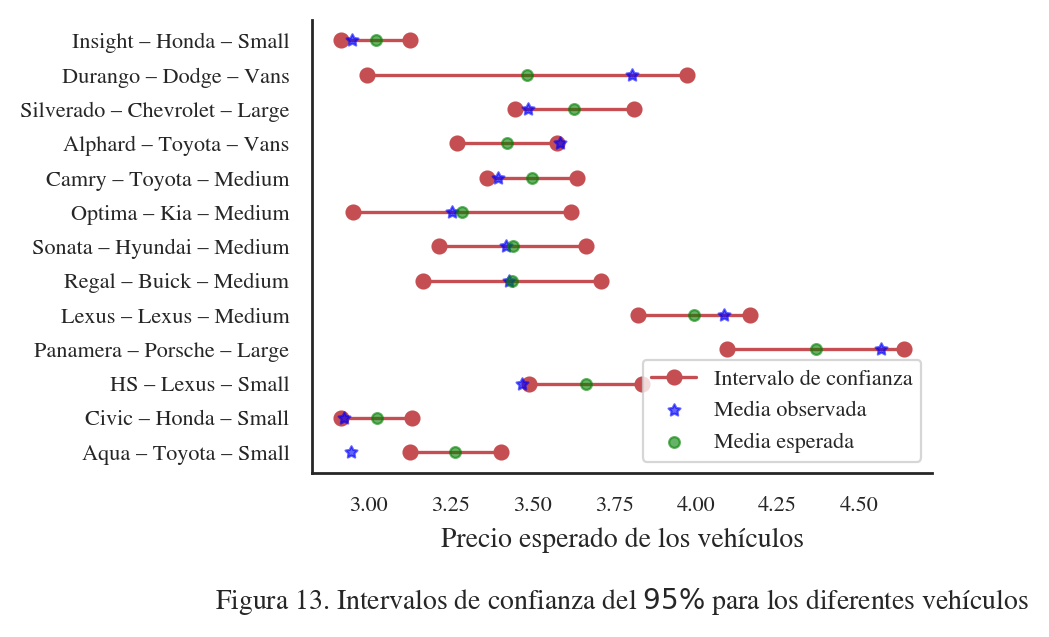

In [38]:
datos_fin_modified['label'] = datos_fin_modified['model'] + ' – ' +  datos_fin_modified['manufacturer'] + ' – ' +  datos_fin_modified['carclass']
datos_fin_modified['y'] = y_mean2
plot_ci(predicted, 
        ci_lower = 'CI_lower', 
        ci_upper = 'CI_upper', 
        y = 'y', 
        y_approx = 'y_approx',
        label = 'label')

En la Figura 13 se pueden observar los resultados obtenidos con el modelo. En la mayoría de los casos se obtuvo una buena predicción ya que los datos observados están dentro del intervalo de confianza de las predicciones del modelo. Finamlente se calculó la $R^2_{predicción}$ mediante la fórmula $R^2_{predicción} = 1 - \frac{PRESS}{SS_T}$ y se obtuvo un valor de 0.9078. Lo que afirma que es una buena predicción de los datos nuevos.


In [39]:
import statsmodels.stats.outliers_influence as oi
infl = oi.OLSInfluence(fitted)
PRESS = infl.ess_press
# print(PRESS)
SSt = fitted.uncentered_tss

# print(dir(fitted))
# print(fitted.uncentered_tss)
R2_predic = 1 - PRESS/SSt
# print(R2_predic)

# Referencias

[1] Lim, D., Jahromi, S., Anderson, T. and Tudorie, A., 2015. *Comparing technological advancement of hybrid electric vehicles (HEV) in different market segments*. Technological Forecasting and Social Change, 97, pp.140-153.